In [4]:
%pylab inline
%config IPCompleter.greedy=True
import numpy as np
from numpy.random import dirichlet, multinomial
import sys
np.random.seed(0)
np.seterr(all='warn')

Populating the interactive namespace from numpy and matplotlib


{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [5]:
def visualizeTopics(model, id2word, n_top_words=12):
    for i, topic in enumerate(model.components_):
        print "Topic {}:".format(i+1)
        print " ".join([id2word[j] 
                        for j in topic.argsort()[:-n_top_words - 1:-1]])

In [6]:
""" Generate toy documents """
K = 3
D = 1000
N = 10
V = 12

# 1) Set alpha and beta for generative model
alpha = np.array([2, 2, 2])
beta = np.array([[0.25, 0.25, 0.25, 0.25, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0.25, 0.25, 0.25, 0.25, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0 ,0, 0.25, 0.25, 0.25, 0.25]])

# 2) Using alpha, sample theta_d for each of the D documents
theta = dirichlet(alpha, D)

# 3) Sample topic z_dn for each of the N words of each of the D documents
# 4) Sample word w_dn from topic beta_k corresponding to z_dn
W = []
for d in range(D):
    # Counts of words for each topic in doc d (e.g [4, 3, 3] for N = 10)
    z_d = multinomial(N, theta[d])
    # One hot matrix of words for doc d
    w_d = []
    for k in xrange(K):
        for i in xrange(z_d[k]):
            w_d.append(multinomial(1, beta[k]))
    W.append(np.array(w_d))

In [7]:
from scipy.special import gamma, digamma
from scipy.stats import multinomial as multinomial_distribution
from scipy.stats import dirichlet as dirichlet_distribution
from sklearn.preprocessing import normalize

class LDA():
    def __init__(self, K=3):
        self.K = K
        # Initialize alpha
        self.alpha = np.ones(self.K) / self.K
        
    # W is a list of D numpy arrays of shape (N_d, V)
    def fit(self, W, max_iter=51, threshold=1e-4, verbose=True):
        self.D = len(W)
        self.V = W[0].shape[1]
        
        # Randomly initialize variational parameters
        # TODO best way to initialize gamma, phi ?
        self.gamma = np.random.rand(self.D, self.K)
        self.phi = [np.random.rand(w_d.shape[0], self.K) for w_d in W]
        self.phi = [phi_d / np.sum(phi_d, axis=1, keepdims=True) \
            for phi_d in self.phi]
        
        # Initialize beta
        self._updateBeta(W)
        
        # Keep track of previous value of lower bound on log likelihood
        old_bound = self._computeBound(W)
        
        # Update phi, gamma, beta iteratively while the bound improves
        for i in xrange(max_iter):
            self._updatePhi(W)
            self._updateGamma()
            self._updateBeta(W)
            current_bound = self._computeBound(W)
            if verbose and i % 10 == 0:
                print "Iter {}, bound = {}".format(i, old_bound)
            if (current_bound - old_bound) < threshold:
                break
            old_bound = current_bound
                
        # Return final state of beta and variational parameters
        self.components_ = self.beta # To match sklearn API
        return self.beta, self.gamma, self.phi
        
    def _updateGamma(self):
        for d in xrange(self.D):
            self.gamma[d] = self.alpha + np.sum(self.phi[d], axis=0)
    
    def _updatePhi(self, W):
        for d in xrange(self.D):
            self.phi[d] = W[d].dot(self.beta.T) * \
                np.exp(digamma(self.gamma[d]))
            self.phi[d] = normalize(self.phi[d], norm="l1", axis=1)
    
    def _updateBeta(self, W):
        self.beta = np.concatenate(self.phi, axis=0).T.dot(
            np.concatenate(W, axis=0))
        self.beta = normalize(self.beta, norm="l1", axis=1)
        
    def _computeBound(self, W):
        # Avoid recomputing expensive expressions
        C1 = digamma(self.gamma)
        C2 = digamma(np.sum(self.gamma, axis=1))
        
        # First three terms correspond to expectation of complete
        # log likelihood under variational distribution
        term1 = self.D * (np.log(gamma(np.sum(self.alpha))) - \
            np.sum(np.log(gamma(self.alpha)))) + \
            np.sum(C1 * (self.alpha - 1)) - np.sum(C2) * \
            np.sum(self.alpha - 1)
        term2 = np.sum(np.array([np.sum(phi_d, axis=0) \
            for phi_d in self.phi]) * C1) - \
            np.array([np.sum(phi_d) for phi_d in self.phi]).dot(C2)
        term3 = np.sum(np.log(self.beta) * np.concatenate(
            self.phi, axis=0).T.dot(np.concatenate(W, axis=0)))
        
        # Sum of entropies of dirichlet variational posteriors
        #term4 = -np.sum(np.log(gamma(np.sum(self.gamma, axis=1)))) + \
        #    np.sum(np.log(gamma(self.gamma))) - \
        #    np.sum((self.gamma - 1) * C1) + \
        #    C2.dot(np.sum(self.gamma - 1, axis=1))
        term4 = 0
        for d in xrange(self.D):
            term4 += dirichlet_distribution.entropy(self.gamma[d])
        
        # Sum of entropies of multinomial variational posteriors
        #term5 = -np.sum(np.concatenate(self.phi, axis=0) * \
        #    np.log(np.concatenate(self.phi, axis=0)))
        term5 = np.sum(multinomial_distribution.entropy(
            1, np.concatenate(self.phi, axis=0)))
        
        # Return lower bound on likelihood 
        # (averaged over total number of words)
        L = term1 + term2 + term3 + term4 + term5
        return L / np.concatenate(W, axis=0).shape[0]
        

In [41]:
class LDA_gibbs:

    def __init__(self, n_topics, alpha=None, id2word=False):
        """
        Parameters
        ----------
        n_topics : int
            number of topics for the model
        alpha : array-like, shape=(n_topics)
            hyperparameter for the model
            controls the likelihood of a topic being assigned
            to a document
        id2word : dictionary
            used to map id of word to real world
            helps to monitor progress of learning
        """
        
        self.n_topics = n_topics
        #initialize alpha
        if alpha is None:
            # default value (from Heinrich, 2005)
            self.alpha = np.ones(self.n_topics) / self.n_topics
        else:
            self.alpha = alpha
        self.sumalpha = np.sum(self.alpha)
        self.id2word = id2word
        
    def fit(self, docs, eta=None, niter=100):
        """
        Learning the parameters for the model
        
        Parameters
        ----------
        docs : list of array-like elements, length = n_docs
            each element is an array of dimensions n_words
            by number of words in vocabulary (n_vocab). The 
            number of words varies from one text to the other.
        threshold : float
            used to stop fitting when the model has converged
            to a final state.
        eta : array-like, shape=(n_vocab)
            hyperparameter for the model
            controls the likelihood of a word being assigned 
            to a topic
        niter : int
            number of gibbs sampling iterations for the training
            of the model
        """
        
        self.n_docs = len(docs)
        self.n_vocab = docs[0].shape[1]
        #initialize eta
        if eta is None:
            #default value (from Heinrich, 2005)
            self.eta = np.ones(self.n_vocab) * 0.01
        else:
            self.eta = eta
        self.sumeta = np.sum(self.eta)
        
        #initializing counters
        self._initialize_counters_train(docs)
        
        for i in xrange(niter):
            
            if i%10 == 0 and i != 0:
                #monitoring progress by showing top words for each topic
                print i
                self._estimate_parameters_train()
                if self.id2word:
                    visualizeTopics(self, id2word)

            self._gibbs_sampling_fit_train(docs)

        #update parameters at the end of training
        self._estimate_parameters_train()
        
    def query_sampling(self, queries, niter=100):
        
        self.n_queries = len(queries)
        
        #initializing counters
        self._initialize_counters_test(queries)
        
        for i in xrange(niter):
            self._gibbs_sampling_fit_test(queries)
        
        #update parameters at the end
        self._estimate_parameters_test()
        
    def perplexity_train(self, docs):
        
        log_likelihood = 0
        tot_num_words = 0
        for i in range(self.n_docs):

            words_occurence = np.sum(docs[i], axis=0)
            
            log_likelihood += np.sum(words_occurence * \
                                     np.log(np.sum((self.beta.T * self.theta[i]), axis=1)))
            
            tot_num_words += len(docs[i])
                    
        perplexity = np.exp(-log_likelihood / tot_num_words)
        
        return perplexity

    
    def perplexity_test(self, queries):
        
        log_likelihood = 0
        tot_num_words = 0
        for i in range(self.n_queries):

            words_occurence = np.sum(queries[i], axis=0)
            
            log_likelihood += np.sum(words_occurence * \
                                     np.log(np.sum((self.beta.T * self.theta_test[i]), axis=1)))
            
            tot_num_words += len(queries[i])
                    
        perplexity = np.exp(-log_likelihood / tot_num_words)
        
        return perplexity
    
    def _initialize_counters_train(self, docs):
        """Initializing counters randomly for the training phase"""

        #initialize arrays to 0
        self.topic_doc_count = np.zeros((self.n_docs, self.n_topics))
        self.term_topic_count = np.zeros((self.n_topics, self.n_vocab))

        #keep track of topic assignment for each word in memory
        self.topic_assign = []

        for i in xrange(self.n_docs):

            n_words = len(docs[i])

            #sample topic randomly for each word in document
            topic = np.random.randint(self.n_topics, size=n_words)
            self.topic_assign.append(topic)

            #count number of words belonging to each topic
            self.topic_doc_count[i] = np.bincount(topic, minlength=self.n_topics)

            #count word occurence for each topic
            self.term_topic_count += np.array([np.sum(docs[i][np.where(topic==j)], axis=0)\
                                               for j in range(self.n_topics)])

            #sum of number of words in each topic
            self.term_topic_sum = np.sum(self.term_topic_count, axis=1)
            
    def _initialize_counters_test(self, queries):
        """Initializing counters randomly for the test phase"""
        
        #initialize arrays to 0
        self.topic_doc_count_test = np.zeros((self.n_queries,self.n_topics))
        self.term_topic_count_test = np.zeros((self.n_topics, self.n_vocab))
        
        #keep track of topic assignment for each word in memory
        self.topic_assign_test = []
        
        for i in xrange(self.n_queries):
            
            n_words = len(queries[i])
            
            #sample topic randomly for each word in query
            topic = np.random.randint(self.n_topics, size=n_words)
            self.topic_assign_test.append(topic)
            
            #count number fo words belonging to each topic
            self.topic_doc_count_test[i] = np.bincount(topic, minlength=self.n_topics)
            
            #count word occurence for each topic
            self.term_topic_count_test += np.array([np.sum(queries[i][np.where(topic==j)], axis=0)\
                                                    for j in range(self.n_topics)])
            
            #sum of number of words in each topic
            self.term_topic_sum_test = np.sum(self.term_topic_count_test, axis=1)
    
    def _gibbs_sampling_fit_train(self, docs):
        """Update counters for each word using gibbs sampling"""
        
        for i in xrange(self.n_docs):
            
            n_words = len(docs[i])
            
            for j in xrange(n_words):
                
                #decrement associated counters
                self.topic_doc_count[i][self.topic_assign[i][j]] -= 1
                self.term_topic_count[self.topic_assign[i][j]] -= docs[i][j]
                self.term_topic_sum[self.topic_assign[i][j]] -= 1
                
                #sample new topic
                word_idx = np.argmax(docs[i][j])               
                prob = (self.topic_doc_count[i] + self.alpha) * \
                        (self.term_topic_count[:, word_idx] + self.eta[word_idx]) /\
                        (np.sum(self.term_topic_count, axis=1) + self.sumeta) /\
                        ((n_words-1) + self.sumalpha)
                prob /= np.sum(prob)                      #normalize
                prob = np.cumsum(prob)                    #cdf
                self.topic_assign[i][j] = np.argmax(prob > np.random.random())

                #increment associated counters
                self.topic_doc_count[i][self.topic_assign[i][j]] += 1
                self.term_topic_count[self.topic_assign[i][j]] += docs[i][j]  
                self.term_topic_sum[self.topic_assign[i][j]] += 1
                
    def _gibbs_sampling_fit_test(self, queries):
        
        for i in xrange(self.n_queries):
            
            n_words = len(queries[i])
            
            for j in xrange(n_words):
                
                #decrement associated counters
                self.topic_doc_count_test[i][self.topic_assign_test[i][j]] -= 1
                self.term_topic_count_test[self.topic_assign_test[i][j]] -= queries[i][j]
                self.term_topic_sum_test[self.topic_assign_test[i][j]] -= 1
                
                #sample new topic
                word_idx = np.argmax(queries[i][j])
                
                prob = (self.topic_doc_count_test[i] + self.alpha) * \
                        (self.term_topic_count_test[:,word_idx] + \
                             self.term_topic_count[:,word_idx] + \
                             self.eta[word_idx]) /\
                        (np.sum(self.term_topic_count_test, axis=1) + \
                             self.term_topic_sum + \
                             self.sumeta) /\
                        ((n_words + self.sumalpha))
                prob /= np.sum(prob)              #normalize
                prob = np.cumsum(prob)            #cdf
                self.topic_assign_test[i][j] = np.argmax(prob > np.random.random())
                
                #increment associated counters
                self.topic_doc_count_test[i][self.topic_assign_test[i][j]] += 1
                self.term_topic_count_test[self.topic_assign_test[i][j]] += queries[i][j]
                self.term_topic_sum_test[self.topic_assign_test[i][j]] += 1
                
    def _estimate_parameters_train(self):
        """Estimate parameters used to make predictions"""
        
        self.beta = np.divide((self.term_topic_count + self.eta).T, 
                             np.sum((self.term_topic_count + self.eta), axis=1)).T
        
        self.theta = np.divide((self.topic_doc_count + self.alpha).T, 
                             np.sum((self.topic_doc_count + self.alpha), axis=1)).T
        
        self.components_ = self.beta
    
    def _estimate_parameters_test(self):
        
                                         
        self.theta_test = np.divide((self.topic_doc_count_test + self.alpha).T,
                                   np.sum((self.topic_doc_count_test + self.alpha), axis=1)).T
        

In [9]:
""" Simple test on toy documents """
model = LDA()
beta, _, _ = model.fit(W)

# We more or less retrieve the beta used in the generating process
print beta

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: underflow encountered in exp


Iter 0, bound = -17.0677205003
Iter 10, bound = -2.73484132991
Iter 20, bound = -2.68272297592
Iter 30, bound = -2.60498487916
Iter 40, bound = -2.54304748958
Iter 50, bound = -2.52028907819
[[  1.16909951e-02   5.73124740e-05   1.52979499e-02   1.81426330e-02
    2.92443035e-02   2.79711349e-02   3.60553959e-02   4.54574605e-02
    1.91830209e-01   1.95422191e-01   2.13527118e-01   2.15303298e-01]
 [  1.85256175e-01   2.08647020e-01   2.10219764e-01   2.27440249e-01
    2.61659358e-03   1.01107956e-02   1.56850425e-02   1.87054548e-02
    2.01845677e-02   4.16485516e-02   2.37349949e-02   3.57507912e-02]
 [  5.07096290e-02   5.39302978e-02   2.80182236e-02   2.42073425e-02
    2.10828664e-01   2.17548102e-01   1.86850044e-01   1.71769691e-01
    2.90199990e-02   2.23790843e-02   4.72491206e-03   1.40110218e-05]]


In [10]:
""" Get the 20 news groups data """
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import pickle

cats = ['soc.religion.christian', 'sci.space', 'talk.politics.mideast',
        'comp.sys.ibm.pc.hardware','rec.sport.baseball']
newsgroups = fetch_20newsgroups(shuffle=True, random_state=1, subset="train",
                                remove=("headers", "footers", "quotes"), categories=cats)

In [11]:
""" Prepare input for sklearn (counts) """
n_features = 2000
vectorizer = CountVectorizer(max_features=n_features, stop_words="english")

# Word counts per document matrix (input for sklearn)
W_counts = vectorizer.fit_transform(newsgroups.data)

# Keep track of vocabulary to visualize top words of each topic
vocabulary = vectorizer.get_feature_names()

In [12]:
""" Prepare input for our model (one hot vectors) """
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from gensim.corpora import Dictionary
import string

# 1) Tokenize document
# 2) Remove stop words
# 3) Lemmatize
lemmatizer = WordNetLemmatizer()
#stemmer = PorterStemmer()
# TODO : treat special list better
# TODO See what count vectorizer does
special = ["''", "'s", "``", "n't", "...", "--"]
stop = set(stopwords.words('english') + \
           list(string.punctuation) + special)
def prepare_document(doc):
    words = [lemmatizer.lemmatize(w) for w in word_tokenize(doc.lower()) 
             if w not in stop] 
    return words


# List of documents (each document is a list of word tokens)
texts = [prepare_document(text) for text in newsgroups.data]

# Create a gensim dictionary for our corpus
dic = Dictionary(texts)

# Keep only k most frequent words
n_features = 2000
dic.filter_extremes(keep_n=n_features)
vocab_size = len(dic.token2id) # Vocabulary size

# List of documents (each document is now a list of word indexes)
# We have removed all words not in the k most frequent words
texts_idx = [[dic.token2id[word] for word in text 
              if word in dic.token2id] for text in texts]

# Convert each index to a one hot vector
W = np.array([np.eye(vocab_size)[text] for text in texts_idx if len(text) > 0])

# Keep track of id to word mapping to visualize top words of topics
id2word = dict([[v, k] for k, v in dic.token2id.items()])



#pickle.dump(W, open("W.p", "wb"))
#pickle.dump(id2word, open("mapping.p", "wb"))

pickle.dump(W, open("/media/patrice/multimedia_2/DATA/W.p", "wb"))
pickle.dump(id2word, open("/media/patrice/multimedia_2/DATA/mapping.p", "wb"))

In [13]:
from sklearn.decomposition import LatentDirichletAllocation

n_topics = 20

def visualizeTopics(model, id2word, n_top_words=12):
    for i, topic in enumerate(model.components_):
        print "Topic {}:".format(i+1)
        print " ".join([id2word[j] 
                        for j in topic.argsort()[:-n_top_words - 1:-1]])

# Compare with sklearn implementation
print "Sklearn model"
lda_sklearn = LatentDirichletAllocation(n_topics=n_topics, 
                                        learning_method="batch")
lda_sklearn.fit(W_counts)
visualizeTopics(lda_sklearn, vocabulary)

# Our model
print "\nOur model"
lda = LDA(K=n_topics)

#W = pickle.load(open("W.p", "rb"))
#id2word = pickle.load(open("mapping.p", "rb"))
W = pickle.load(open("/media/patrice/multimedia_2/DATA/W.p", "rb"))
id2word = pickle.load(open("/media/patrice/multimedia_2/DATA/mapping.p", "rb"))

lda.fit(W, verbose=True)
visualizeTopics(lda, id2word)

Sklearn model


/usr/local/lib/python2.7/dist-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Topic 1:
earth spacecraft lebanese orbit moon probe mars time surface sun lunar mission
Topic 2:
church spirit father faith catholic holy son book authority christian jesus st
Topic 3:
said people didn know don went just say came like going time
Topic 4:
nasa space available 14 data information 12 ftp 10 11 gov faq
Topic 5:
space station cost rom systems theory universe larson technology feature high supports
Topic 6:
use just like work software does tape need know sys adaptec don
Topic 7:
drive drives disk hard bios controller slave master floppy jumper 16 pin
Topic 8:
scsi ide bus controller isa drive transfer pc sec data dma mac
Topic 9:
israel jews israeli armenian people war armenians arab state peace arabs genocide
Topic 10:
card bit thanks dos problem windows pc monitor does using know use
Topic 11:
edu com os adam mail comp cs ac ca os2 easter net
Topic 12:
turkish armenian turkey greek armenians people armenia turks said azerbaijan government greece
Topic 13:
year good think g

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: underflow encountered in exp
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: underflow encountered in multiply


Iter 0, bound = -103.466210523
Iter 10, bound = nan
Iter 20, bound = nan
Iter 30, bound = nan


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:1438: RuntimeWarning: underflow encountered in true_divide
  X /= norms[:, np.newaxis]
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: underflow encountered in multiply
/home/patrice/.local/lib/python2.7/site-packages/scipy/stats/_discrete_distns.py:52: RuntimeWarning: underflow encountered in exp
  return exp(self._logpmf(x, n, p))
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in multiply


Iter 40, bound = nan


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: underflow encountered in multiply


Iter 50, bound = nan
Topic 1:
space launch satellite mission program year nasa first would shuttle station u
Topic 2:
drive would scsi israel time israeli one get ide question could arab
Topic 3:
say said one know go people going thing time get well like
Topic 4:
armenian people armenia russian azeri turkish azerbaijan genocide turk said one massacre
Topic 5:
space system nasa satellite orbit earth lunar center available also 1 data
Topic 6:
god jesus one christ church sin father would u christian say son
Topic 7:
game year team would run good one last player hit win first
Topic 8:
jew one time many greek even woman child jewish would year like
Topic 9:
turkish jew armenian greek turkey university government history turk jewish people nazi
Topic 10:
driver data drive card also disk program system file problem use window
Topic 11:
church would people one pope year like think know catholic much time
Topic 12:
1 0 2 3 4 5 lost 6 game team please n
Topic 13:
god would christian people one 

In [14]:
#results for the LDA implementation using Gibbs sampling
n_topics = 12
lda_gibbs = LDA_gibbs(n_topics)
lda_gibbs.fit(W, niter=20)
        
visualizeTopics(lda_gibbs, id2word)

0
10
Topic 1:
would israel know question people like want get think answer see life
Topic 2:
1 drive 2 0 card 3 4 5 controller system driver hard
Topic 3:
year game would team get good think run last one player like
Topic 4:
one book greek christian also church world religion question many may read
Topic 5:
jew right israeli israel jewish people state would arab human nazi country
Topic 6:
space launch nasa satellite program orbit system data shuttle lunar rocket center
Topic 7:
drive scsi problem get ide use know one would system like 'm
Topic 8:
one said u people say know could would woman went go came
Topic 9:
god jesus believe say think christian christ one church would people sin
Topic 10:
would one thing mission like way much could moon work get new
Topic 11:
university number history group april also first power study political army book
Topic 12:
armenian turkish turkey people turk armenia russian government village genocide killed new


In [15]:
#loading and preprocessing test data
newsgroups_test = fetch_20newsgroups(shuffle=True, random_state=1, subset="test",
                                remove=("headers", "footers", "quotes"), categories=cats)

# List of documents (each document is a list of word tokens)
texts_test = [prepare_document(text) for text in newsgroups_test.data]

# List of documents (each document is now a list of word indexes)
# We have removed all words not in the k most frequent words
texts_idx_test = [[dic.token2id[word] for word in text 
              if word in dic.token2id] for text in texts_test]

# Convert each index to a one hot vector
W_test = np.array([np.eye(vocab_size)[text] for text in texts_idx_test if len(text) > 0])

# Keep track of id to word mapping to visualize top words of topics
id2word = dict([[v, k] for k, v in dic.token2id.items()])


pickle.dump(W_test, open("/media/patrice/multimedia_2/DATA/W_test.p", "wb"))


In [16]:
""" Visualize most likely topic assignment for each word 
    [if p(most likely topic) < threshold, don't assign a topic]
    and visualize expected distribution over topics
    Inputs:
        model, our trained lda model
        document_idx, index of document to visualize
        id2word, mapping from word index to word string
        topic2word, mapping from topic index to topic string
        threshold, float in [0.0, 1.0]
    """
def visualizeWordAssignments(model, document_idx, id2word, 
                             topic2word, threshold=0.9):
    # We add a column with value threshold so that if the index of this 
    # column gets selected by the argmax operation, we don't assign a topic
    col = np.ones((model.phi[document_idx].shape[0], 1)) * threshold
    col_index = model.phi[document_idx].shape[1]
    topic2word[col_index] = " "
    word_topic_probas = np.concatenate(
        (model.phi[document_idx], col), axis=1)
    
    # Expected distribution over topics
    doc_topic_probas = dirichlet_distribution.mean(
        model.gamma[document_idx])
    
    print "DOCUMENT:"
    print newsgroups.data[document_idx]
    
    print "\nEXPECTED PROBA DISTRIB OVER TOPICS:"
    for i in xrange(len(doc_topic_probas)):
        print "{}: {}".format(topic2word[i], doc_topic_probas[i])
        
    print "\nWORD TOPIC ASSIGNMENTS:"
    for word_idx, topic_idx in zip(texts_idx[document_idx], 
                                   np.argmax(word_topic_probas, axis=1)): 
        print "{} -> {}".format(id2word[word_idx], topic2word[topic_idx])

In [17]:
topic2word = {0: "topic 1", 1: "topic 2", 2: "topic 3", 3: "topic 4"}
visualizeWordAssignments(lda, 0, id2word, topic2word)

DOCUMENT:

In the "sex ed" portion of the  high school "health" course I took
in 1984, it was impressed that the only 100% positive way to *not*
get pregnant was to *not* have sex.

Other methods of contraception were discussed, in the framework of
a chart which showed both the _expected_ failure rate (theoretical,
assumes no mistakes) and the _actual_ failure rate (based on research).
Top of the chart was something like this:


 Method                  Expected         Actual 
 ------                 Failure Rate    Failure Rate
 Abstinence                 0%              0% 


And NFP (Natural Family Planning) was on the bottom. The teacher even
said, "I've had some students tell me that they can't use anything for
birth control because they're Catholic. Well, if you're not married and
you're a practicing Catholic, the *top* of the list is your slot, not 
the *bottom*.  Even if you're not religious, the top of the list is
safest."

Yes, this was a public school and after Dr Koop's "f

KeyError: 4

In [ ]:
topic2word = {0: "space", 1: "religion"}
visualizeWordAssignments(lda, 6, id2word, topic2word)

In [ ]:
# TODO Perform inference on new documents
# only E-step (estimate phi and gamma) until the end

In [18]:
W = pickle.load(open("/media/patrice/multimedia_2/DATA/W.p", "rb"))
id2word = pickle.load(open("/media/patrice/multimedia_2/DATA/mapping.p", "rb"))

#W = pickle.load(open("W_train.p", "rb"))
W_test = pickle.load(open("/media/patrice/multimedia_2/DATA/W_test.p", "rb"))




number of topics : 2
Training model
Testing model

number of topics : 4
Training model
Testing model

number of topics : 6
Training model
Testing model

number of topics : 8
Training model
Testing model

number of topics : 10
Training model
Testing model

number of topics : 12
Training model
Testing model

number of topics : 14
Training model
Testing model

number of topics : 16
Training model
Testing model

number of topics : 18
Training model
Testing model

number of topics : 20
Training model
Testing model

number of topics : 22
Training model
Testing model

number of topics : 24
Training model
Testing model

number of topics : 26
Training model
Testing model

number of topics : 28
Training model
Testing model


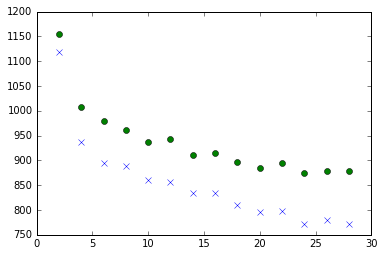

In [43]:
perp_train = []
perp_test = []

topic_numbers = range(2,30,2)


for n_topics in topic_numbers:
    #results for the LDA implementation using Gibbs sampling
    print "\nnumber of topics : %d"%n_topics
    print "Training model"
    lda_gibbs = LDA_gibbs(n_topics)
    lda_gibbs.fit(W, niter=10)
    perp_train.append(lda_gibbs.perplexity_train(W))

    print "Testing model"
    lda_gibbs.query_sampling(W_test, niter=10)
    perp_test.append(lda_gibbs.perplexity_test(W_test))


perp_train = np.array(perp_train)
perp_test = np.array(perp_test)

np.savetxt('perp_train_gibbs.txt', perp_train)
np.savetxt('perp_test_gibbs.txt', perp_test)

plt.plot(topic_numbers, perp_train,'x')
plt.plot(topic_numbers, perp_test, 'o')
plt.show()